In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
import datetime as dt
sns.set(style="whitegrid")

In [123]:
df = pd.read_csv(r"C:\Users\Mini Max\Desktop\data_set\online_retail_II.csv\online_retail_II.csv")
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [125]:
con = duckdb.connect()
con.register('raw_data', df)

In [126]:
# Extracting and cleaning transaction data for cohort analysis

df = con.query("""
    select "Customer ID" as customer_id,
        "InvoiceDate" as invoice_date,
        "Quantity" as quantity,
        "Price" as price,
        "Invoice" as invoice_no,
        "Country" as country,
        (Quantity * Price) as total_revenue
    from raw_data
    where "Customer ID" is not null
    and "Quantity" > 0
    and "Price" >0
    and "Invoice" not like 'C%'
    """).df()
df.copy()

,customer_id,invoice_date,quantity,price,invoice_no,country,total_revenue
0,13085.0,2009-12-01 07:45:00,12,6.95,489434,United Kingdom,83.40
1,13085.0,2009-12-01 07:45:00,12,6.75,489434,United Kingdom,81.00
2,13085.0,2009-12-01 07:45:00,12,6.75,489434,United Kingdom,81.00
3,13085.0,2009-12-01 07:45:00,48,2.10,489434,United Kingdom,100.80
4,13085.0,2009-12-01 07:45:00,24,1.25,489434,United Kingdom,30.00
...,...,...,...,...,...,...,...
805544,12680.0,2011-12-09 12:50:00,6,2.10,581587,France,12.60
805545,12680.0,2011-12-09 12:50:00,4,4.15,581587,France,16.60
805546,12680.0,2011-12-09 12:50:00,4,4.15,581587,France,16.60
805547,12680.0,2011-12-09 12:50:00,3,4.95,581587,France,14.85


In [127]:
# Removing duplicate transactions to ensure data integrity

rows_before = len(df)

df = df.drop_duplicates()

rows_after = len(df)

print(rows_before)
print(rows_after)
print(rows_before - rows_after)

805549
490658
314891


In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 490658 entries, 0 to 805548
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   customer_id    490658 non-null  float64
 1   invoice_date   490658 non-null  object 
 2   quantity       490658 non-null  int64  
 3   price          490658 non-null  float64
 4   invoice_no     490658 non-null  object 
 5   country        490658 non-null  object 
 6   total_revenue  490658 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 29.9+ MB


In [129]:
# Standardize datetime

df['invoice_date'] = pd.to_datetime(df['invoice_date'])
df['invoice_month'] = df['invoice_date'].dt.to_period('M')
df['customer_id'] = df['customer_id'].astype(str)

In [130]:
# Statistics Summary

df.describe(include='all')

,customer_id,invoice_date,quantity,price,invoice_no,country,total_revenue,invoice_month
count,490658,490658,490658.000000,490658.000000,490658,490658,490658.000000,490658
unique,5878,NaN,NaN,NaN,36969,41,NaN,25
top,17841.0,NaN,NaN,NaN,567183,United Kingdom,NaN,2011-11
freq,6847,NaN,NaN,NaN,167,442079,NaN,40075
mean,NaN,2011-01-01 15:51:48.602936832,15.388929,3.693808,NaN,NaN,26.297520,NaN
min,NaN,2009-12-01 07:45:00,1.000000,0.001000,NaN,NaN,0.001000,NaN
25%,NaN,2010-06-30 16:14:00,2.000000,1.250000,NaN,NaN,5.900000,NaN
50%,NaN,2010-12-02 15:26:00,6.000000,2.080000,NaN,NaN,13.500000,NaN
75%,NaN,2011-07-29 11:56:00,12.000000,4.150000,NaN,NaN,20.800000,NaN
max,NaN,2011-12-09 12:50:00,80995.000000,10953.500000,NaN,NaN,168469.600000,NaN


In [131]:
# Check for null
df.isnull().sum()

customer_id      0
invoice_date     0
quantity         0
price            0
invoice_no       0
country          0
total_revenue    0
invoice_month    0
dtype: int64

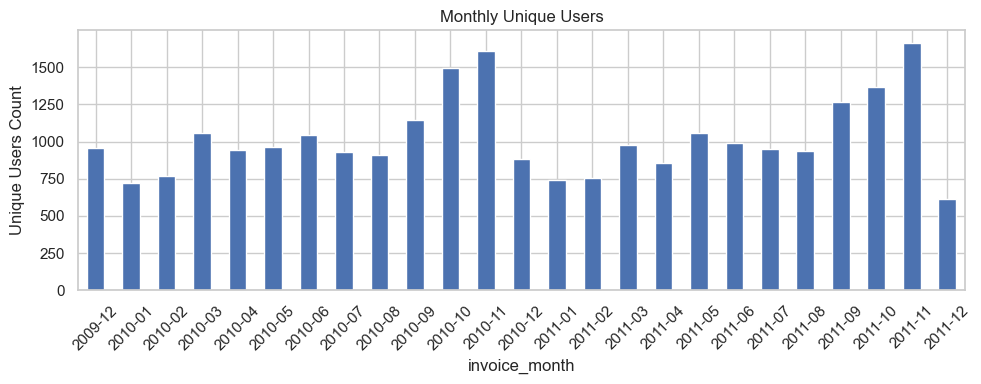

In [132]:
# Monthly total revenue

monthly_active_users = df.groupby('invoice_month')['customer_id'].nunique()
monthly_active_users.plot(kind='bar', figsize=(10, 4))
plt.title('Monthly Unique Users')
plt.ylabel('Unique Users Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

User Activity & Seasonality Analysis The number of unique users shows a strong and stable trend throughout the observation period, consistently maintaining a base of 700 to 1,000 unique customers per month. The analysis reveals a clear seasonal pattern: there is a significant surge in activity towards the end of the year. Notably, the peak in November 2011 almost mirrors the performance of November 2010, reaching the highest engagement levels in the dataset. This repeatability confirms that the business has a predictable and successful seasonal cycle, with November being the most critical month for customer acquisition and engagement.

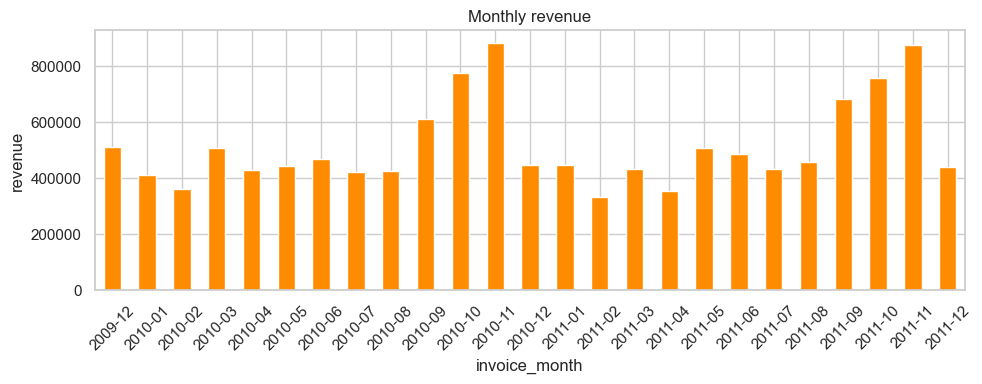

In [133]:
# Monthly total revenue

monthly_revenue = df.groupby('invoice_month')['total_revenue'].sum()
monthly_revenue.plot(kind='bar', color='darkorange',  figsize=(10, 4))
plt.title('Monthly revenue')
plt.ylabel('revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The monthly revenue shows a direct synchronization with user activity. The revenue pattern nearly perfectly mirrors the unique user distribution, including the repeating peaks in November 2010 and 2011. This correlation indicates a highly stable average order value and confirms a predictable business model where revenue scales linearly based on the volume of the active audience.

In [134]:
# Defining cohorts and calculating lifetime index

df['cohort_month'] = df.groupby('customer_id')['invoice_month'].transform('min')
df['cohort_index'] = (df['invoice_month'] - df['cohort_month']).apply(lambda x: x.n)

# Cohort retention calculation
cohort_data = df.groupby(['cohort_month', 'cohort_index'])['customer_id'].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index='cohort_month', columns='cohort_index', values='customer_id')

cohort_sizes = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_sizes, axis=0)

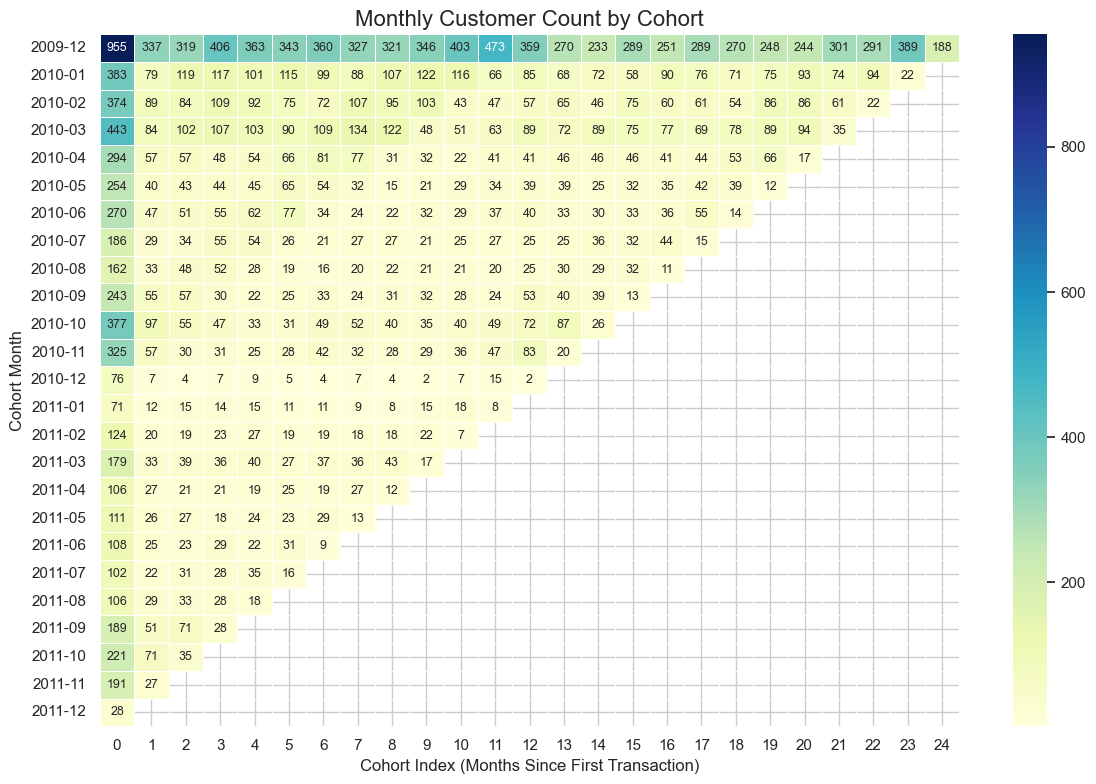

In [135]:
# Cohort customer count heatmap

plt.figure(figsize=(12, 8))
sns.heatmap(cohort_pivot,
            annot=True,
            fmt='.0f',
            cmap='YlGnBu',
            linewidths=0.5,
            annot_kws={"size": 9})
plt.title('Monthly Customer Count by Cohort', fontsize=16)
plt.xlabel('Cohort Index (Months Since First Transaction)')
plt.ylabel('Cohort Month')
plt.tight_layout()
plt.show()

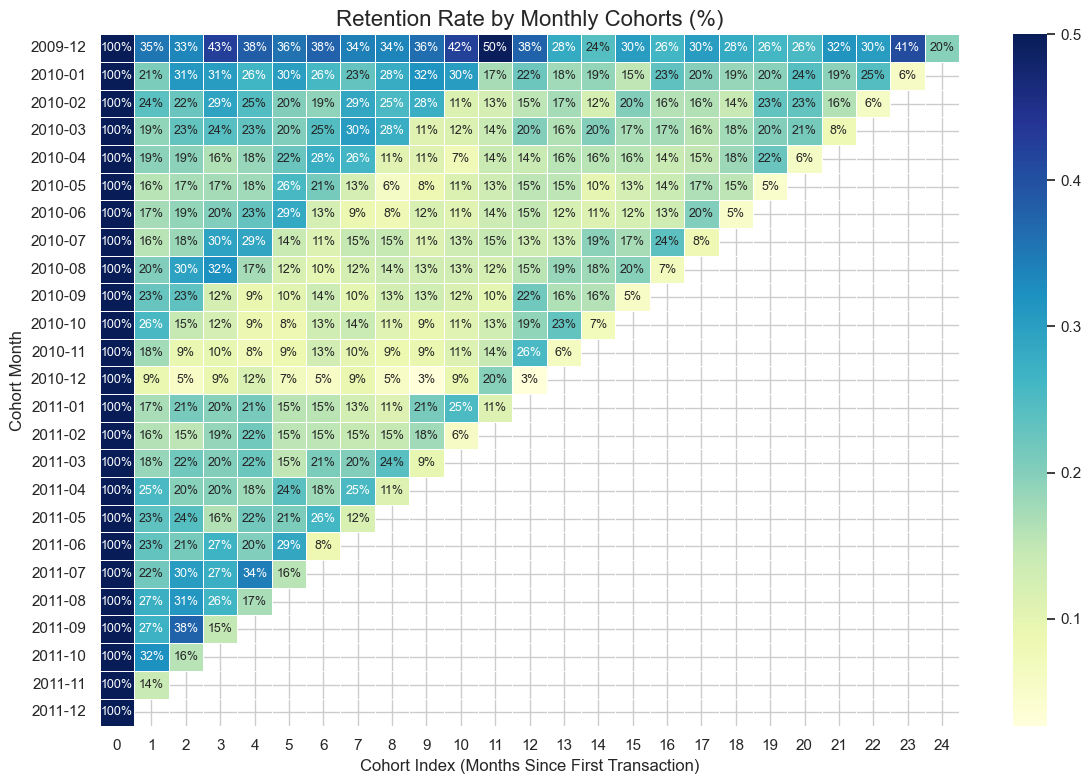

In [136]:
# Customer retention rate heatmap in percentage

plt.figure(figsize=(12, 8))
sns.heatmap(retention,
            annot=True,
            fmt='.0%',
            cmap='YlGnBu',
            linewidths=0.5,
            vmax=0.5,
            annot_kws={"size": 9})
plt.title('Retention Rate by Monthly Cohorts (%)', fontsize=16)
plt.xlabel('Cohort Index (Months Since First Transaction)')
plt.ylabel('Cohort Month')
plt.tight_layout()
plt.show()

The cohort analysis reveals a strong and stable foundation for the business, led by the December 2009 cohort, which started with 955 users and maintained an exceptional retention rate between 30% and 50% for nearly two years. While newer cohorts are smaller (typically 100 to 400 users), they demonstrate a consistent retention pattern, stabilizing at 15% to 25% after the initial second-month drop-off. Notably, the data shows that many customers return specifically during peak seasons, leading to natural fluctuations in engagement during off-peak periods. This cyclical behavior, combined with the presence of 389 active users from the initial cohort in its 23rd month, confirms a highly loyal customer base with a predictable long-term engagement model driven by seasonal demand.

In [137]:
# Revenue retention calculation

revenue_cohorts = df.groupby(['cohort_month', 'cohort_index'])['total_revenue'].sum().reset_index()

revenue_matrix = revenue_cohorts.pivot(index=['cohort_month'],
                                       columns=['cohort_index'],
                                       values=['total_revenue'])

# Dividing by the first month's revenue to get the percentage
revenue_retention = revenue_matrix.divide(revenue_matrix.iloc[:, 0], axis=0)

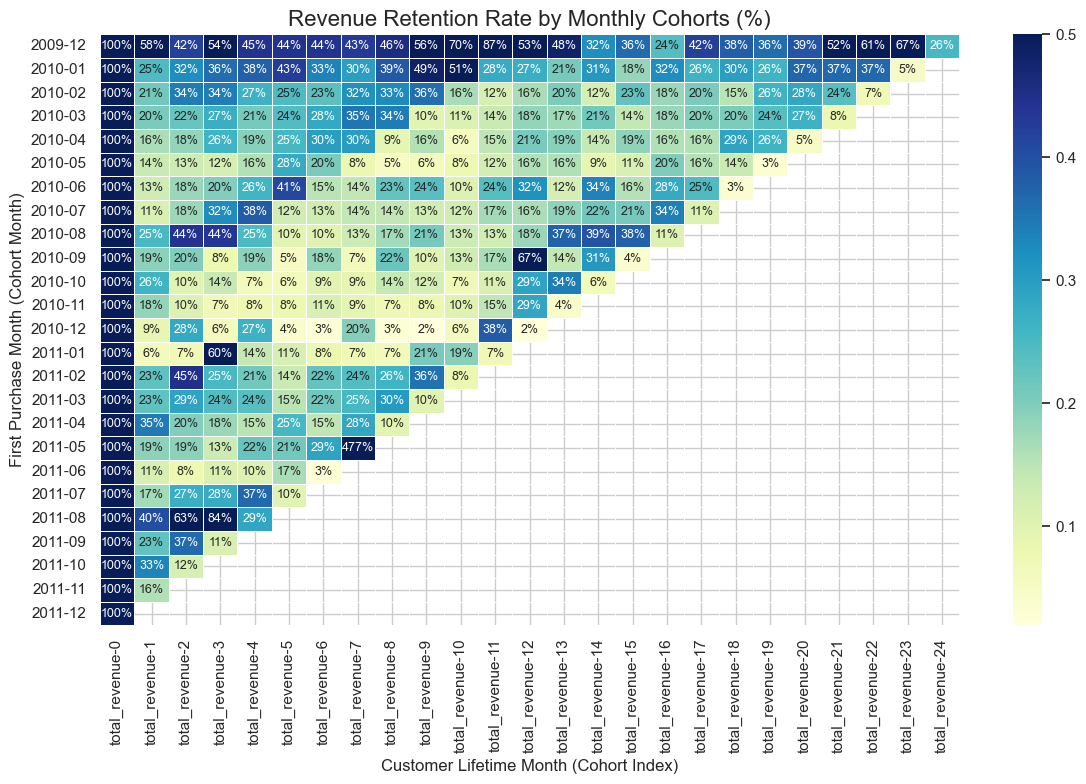

In [138]:
# Revenue retention rate heatmap in percentage

plt.figure(figsize=(12, 8))
sns.heatmap(revenue_retention,
            annot=True,
            fmt='.0%',
            cmap='YlGnBu',
            linewidths=0.5,
            vmax=0.5,
            annot_kws={"size": 9})

plt.title('Revenue Retention Rate by Monthly Cohorts (%)', fontsize=16)
plt.xlabel('Customer Lifetime Month (Cohort Index)')
plt.ylabel('First Purchase Month (Cohort Month)')
plt.tight_layout()
plt.show()

The revenue retention heatmap confirms that the business maintains high financial value across its core cohorts. The December 2009 cohort is particularly dominant, showing revenue retention rates frequently exceeding 50%, and even peaking at 87% in its 12th month. This indicates that long-term customers not only stay active but often increase their spending over time.